# load the necessary package and data
Make sure you install the Monocle 2, DDRTree and xacHelper packages correctly in your environment first

In [1]:
#load all the necessary libraries 
#(use suppressMessages and , quietly = TRUE, warn.conflicts = FALSE argument to suppress the library loading messages)
suppressMessages(library(monocle))
suppressMessages(library(plyr))
suppressMessages(library(dplyr))
suppressMessages(library(destiny))
suppressMessages(library(xacHelper))
suppressMessages(library(grid))

Warning message:
“package ‘destiny’ was built under R version 3.3.3”

# load the RData from Maren Büttner, shared by Fabian

In [2]:
# this RData is from Maren Büttner (https://github.com/theislab/scAnalysisTutorial)
load('./Paul_Cell_MARSseq_GSE72857.RData') 
# the following code is used to select feature genes used by Maren 
gene.names <-sapply(strsplit(rownames(data.debatched), ";"), "[", 1)
is.informative <- gene.names %in% info.genes[order(info.genes)]
data.info.genes <- data.debatched[is.informative,]
rownames(data.info.genes) <- gene.names[is.informative]

# create the cds from stratch 
1. we downloaded the GSE72857_umitab.txt.gz / GSE72857_experimental_design.txt.gz file from GEO website 
2. we obtained MAP.csv from Ido Amit group through email 
3. we intersect the gene names from the GSE72857_umitab file and those from the info.genes created by Maren Büttner to define the informative genes. 
4. we used the expression matrix from her to create the cds (Steps 3 & 4 are used for the purpose of consistency with DPT)

The code for making this cds is in fig4_marseq.r file 

In [3]:
################################################################################################################################################
# obtain this mat file from Ido Amit group  
MAP_cells_clusters <- read.csv('/Users/xqiu/Downloads/MAP.csv', header = F)
row.names(MAP_cells_clusters) <- MAP_cells_clusters$V1

#filtering cells to include only the ones which were assigned a cluster id: 
valid_subset_GSE72857_exprs <- read.table('/Users/xqiu/Downloads/GSE72857_umitab.txt', header = T, row.names = 1)
design_mat <- read.table('/Users/xqiu/Dropbox (Personal)/Projects/DDRTree_fstree/DDRTree_fstree/csv_data/GSE72857_experimental_design.txt', header = T, row.names = 1, skip = 19, sep = '\t')
design_mat$cluster <- MAP_cells_clusters[row.names(design_mat), 'V2']
valid_design_mat <- subset(design_mat, !is.na(cluster))

setdiff(colnames(valid_subset_GSE72857_exprs[, row.names(subset(design_mat, Batch_desc %in% c( 'Unsorted myeloid')) )])[(apply(valid_subset_GSE72857_exprs[, row.names(subset(design_mat, Batch_desc %in% c( 'Unsorted myeloid')) )], 2, sum) > 500)], row.names(MAP_cells_clusters))
colSums(valid_subset_GSE72857_exprs[, c('W31450', 'W36988')]) #both cells have UMI counts 501 

# Get the intersect gene used by Maren Büttner and the genes we have 
common_genes <- rownames(valid_subset_GSE72857_exprs)[rownames(valid_subset_GSE72857_exprs) %in% info.genes]
fd <- new("AnnotatedDataFrame", data = data.frame(gene_short_name = common_genes, row.names = common_genes))
pd <- new("AnnotatedDataFrame", data = valid_design_mat)

# create a CDS with data.info.genes 
valid_subset_GSE72857_cds <- newCellDataSet(as(as.matrix(data.info.genes[common_genes, ]), 'sparseMatrix'), 
                                            phenoData = pd, 
                                            featureData = fd,
                                            lowerDetectionLimit=1,
                                            expressionFamily=negbinomial.size())
valid_subset_GSE72857_cds <- estimateSizeFactors(valid_subset_GSE72857_cds)
valid_subset_GSE72857_cds <- estimateDispersions(valid_subset_GSE72857_cds)

pData(valid_subset_GSE72857_cds)$cell_type <- revalue(as.character(pData(valid_subset_GSE72857_cds)$cluster), 
                                                      c("1" = 'erythroid', "2" = 'erythroid', "3" = 'erythroid', "4" = 'erythroid', "5" = 'erythroid', "6" = 'erythroid', 
                                                        "7" = 'CMP', "8" = 'CMP', "9" = 'CMP', "10" = 'CMP',
                                                        "11" = 'DC', 
                                                        "12" = 'GMP', "13" = 'GMP', "14" = 'GMP', "15" = 'GMP', "16" = 'GMP', "17" = 'GMP', "18" = 'GMP', 
                                                        "19" = 'lymphoid'))

#remove all lymphoid cells
valid_subset_GSE72857_cds <- valid_subset_GSE72857_cds[, pData(valid_subset_GSE72857_cds)$cell_type != 'lymphoid']

[1] "W31450" "W36988"

W31450 W36988 
   501    501

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message:
“glm.fit: algorithm did not converge”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y ==

# reconstruct the trajectory with Monocle 2 
1. Run Monocle 2 by default excepting that we we set max_component to 10 and norm_method to log. 

In [4]:
valid_subset_GSE72857_cds2 <- reduceDimension(valid_subset_GSE72857_cds, norm_method = 'log', verbose = F, max_components = 10) 
valid_subset_GSE72857_cds2 <- orderCells(valid_subset_GSE72857_cds2, reverse = T)

Warning message in if (reduction_method == "DPT") {:
“the condition has length > 1 and only the first element will be used”

# make the multiple branch plot 
Now we can set the root state for the tree layout as state 10, and 
1. show that we can reproduce Figure 16A 
2. show that we can reproduce Figure 16B

The following `from` values were not present in `x`: 19


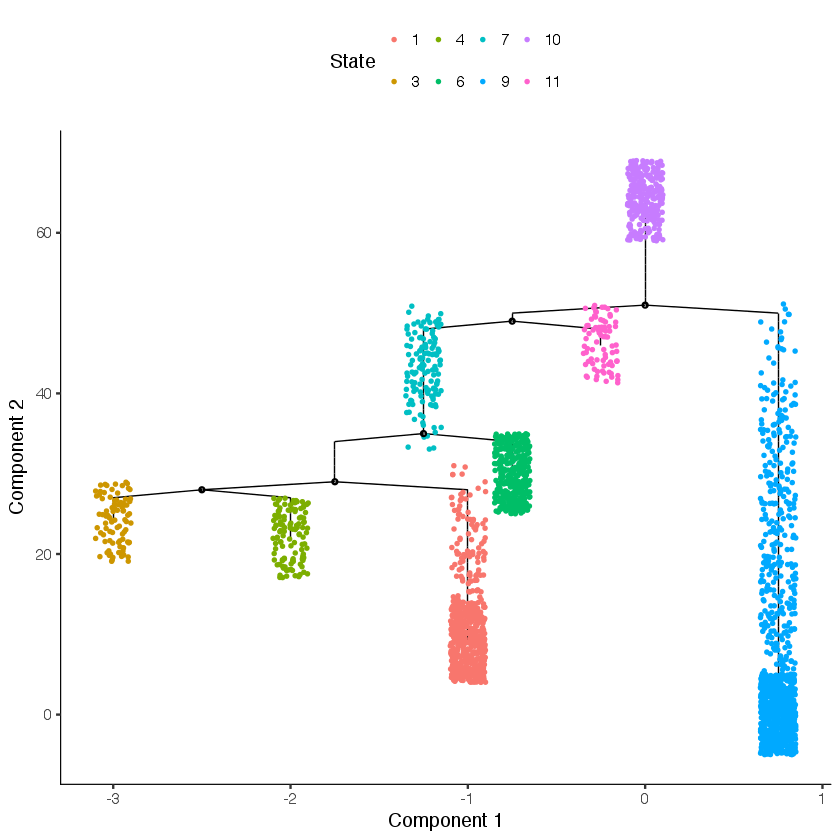

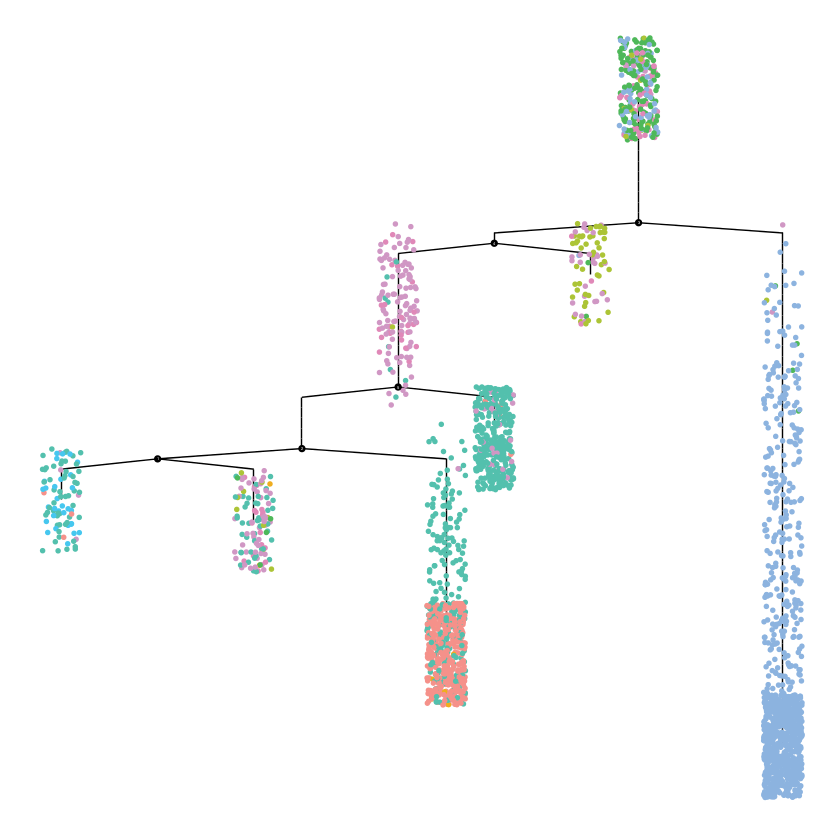

In [5]:
detailed_cell_type_color <- c("B" = "#E088B8", "DC" = "#46C7EF", "E" = "#EFAD1E", "Ery" = "#8CB3DF", "M" = "#53C0AD", "MP/EP" = "#4EB859", "GMP" = "#D097C4", "MK" = "#ACC436", "N" = "#F5918A")

pData(valid_subset_GSE72857_cds2)$cell_type2 <- revalue(as.character(pData(valid_subset_GSE72857_cds2)$cluster), 
                                                        c("1" = 'Ery', "2" = 'Ery', "3" = 'Ery', "4" = 'Ery', "5" = 'Ery', "6" = 'Ery', 
                                                          "7" = 'MP/EP', "8" = 'MK', "9" = 'GMP', "10" = 'GMP',
                                                          "11" = 'DC', 
                                                          "12" = 'B', "13" = 'B', "14" = 'M', "15" = 'M', "16" = 'N', "17" = 'N', "18" = 'E', 
                                                          "19" = 'lymphoid'))

# we find a typo where the number labels of states 4 and 1 are swapped in the figure 16A, we will correct this. 
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'State', show_branch_points = T, 
                             cell_size = 0.5, cell_link_size = 0.3, root_states = c(10))  

plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'as.factor(cell_type2)', show_branch_points = T, 
                             cell_size = 0.5, cell_link_size = 0.3, root_states = c(10)) + scale_size(range = c(0.2, 0.2)) +
  nm_theme() + theme(axis.text.x = element_text(angle = 30, hjust = 1)) + theme (legend.position="right", legend.title=element_blank()) +
  theme (legend.position="top", legend.title=element_blank()) + theme (legend.position="none", legend.title=element_blank()) + scale_color_manual(values = detailed_cell_type_color) + theme_void() + theme (legend.position="none", legend.title=element_blank())

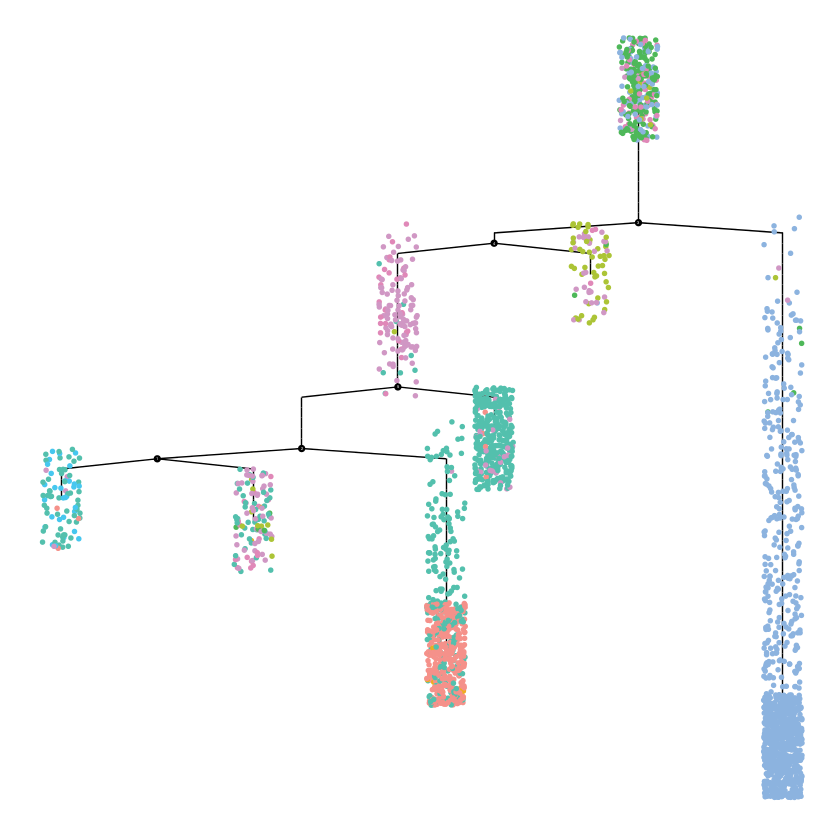

In [6]:
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'as.factor(cell_type2)', show_branch_points = T, 
                             cell_size = 0.5, cell_link_size = 0.3, root_states = c(10)) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + theme (legend.position="right", legend.title=element_blank()) +
  theme (legend.position="top", legend.title=element_blank()) + theme (legend.position="none", legend.title=element_blank()) + scale_color_manual(values = detailed_cell_type_color) + theme_void() + theme (legend.position="none", legend.title=element_blank())

# reproduce Figure 16c
1. Calculate the distribution of each state into the cell type classification from the original study

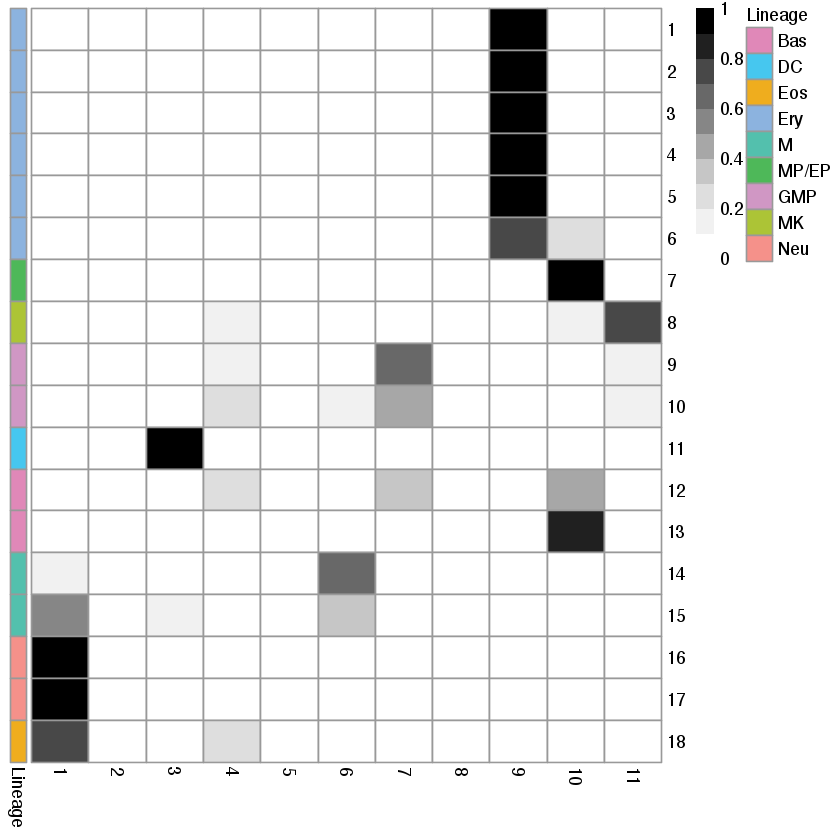

In [7]:
annotation_row = data.frame(`Lineage` = c("1" = 'Ery', "2" = 'Ery', "3" = 'Ery', "4" = 'Ery', "5" = 'Ery', "6" = 'Ery', 
                                          "7" = 'MP/EP', "8" = 'MK', "9" = 'GMP', "10" = 'GMP',
                                          "11" = 'DC', 
                                          "12" = 'Bas', "13" = 'Bas', "14" = 'M', "15" = 'M', "16" = 'Neu', "17" = 'Neu', "18" = 'Eos', 
                                          "19" = 'lymphoid')) 
state_cluster_stat <- table(pData(valid_subset_GSE72857_cds2)[, c('State', 'cluster')])

state_cluster_stat <- apply(state_cluster_stat, 2, function(x) x / sum(x))
state_cluster_stat_ordered <- t(state_cluster_stat)
detailed_cell_type_color <- c("Bas" = "#E088B8", "DC" = "#46C7EF", "Eos" = "#EFAD1E", "Ery" = "#8CB3DF", "M" = "#53C0AD", "MP/EP" = "#4EB859", "GMP" = "#D097C4", "MK" = "#ACC436", "Neu" = "#F5918A")
annotation_colors = list(`Lineage` = detailed_cell_type_color)
pheatmap::pheatmap(state_cluster_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10), 
                   annotation_row = annotation_row, annotation_colors = annotation_colors)

# show the session info

In [8]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X Yosemite 10.10.5

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] grid      splines   stats4    parallel  stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] xacHelper_0.0.1.0000   HSMMSingleCell_0.108.0 destiny_2.0.8         
 [4] dplyr_0.5.0            plyr_1.8.4             monocle_2.2.0         
 [7] L1Graph_0.1.0          lpSolveAPI_5.5.2.0-17  simplePPT_0.1.0       
[10] igraph_1.0.1           DDRTree_0.1.5          irlba_2.2.1           
[13] VGAM_1.0-3             ggplot2_2.2.1          Biobase_2.34.0        
[16] BiocGenerics_0.20.0    Matrix_1.2-10         

loaded via a namespace (and not attached):
 [1] nlme_3.1-131         matrixStats_0.52.2   pbkrtest_0.4-7      
 [4] xts_0.9-7            RColorBrewer_1.1-2   repr_0.12.0         
 [7] tools_3.3.2          backports_1.0.5 